In [88]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import random
import numpy as np
import copy

%matplotlib inline
%config InlineBackend.figure_format ='retina'

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [5]:
images, labels = fetch_openml('mnist_784', return_X_y=True, as_frame=False)

In [6]:
train_test_split?

In [7]:
train_images, test_images, train_labels, test_labels = \
            train_test_split(images, labels, random_state=42) #train_size=10000, stratify=labels

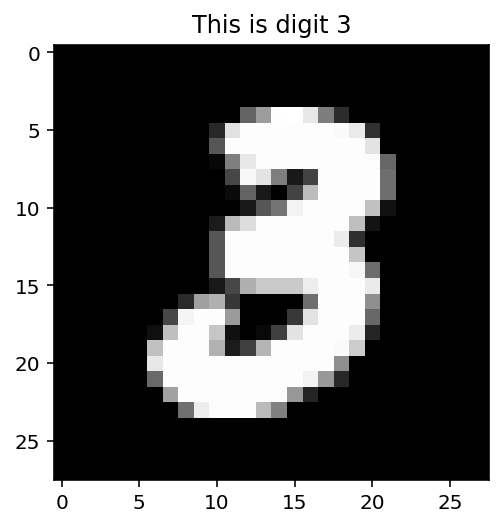

In [9]:
SAMPLE_NUM = 777

plt.imshow(train_images[SAMPLE_NUM].reshape(28, 28), cmap='gray')
plt.title(f'This is digit {train_labels[SAMPLE_NUM]}')
plt.show()

To plot everything in grayscale:

In [10]:
# plt.gray()
# or
plt.rcParams['image.cmap'] = 'gray'

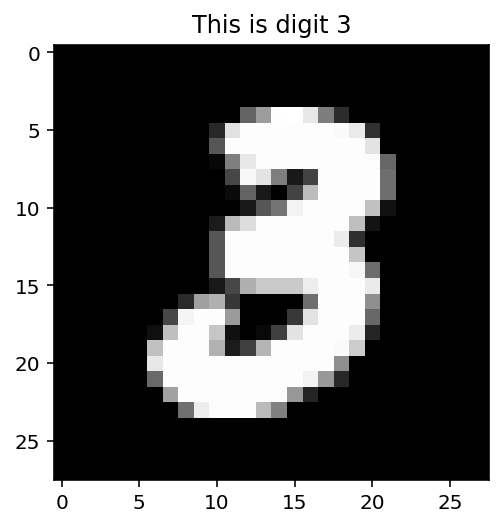

In [11]:
plt.imshow(train_images[SAMPLE_NUM].reshape(28, 28))
plt.title(f'This is digit {train_labels[SAMPLE_NUM]}')
plt.show()

In [12]:
def select_with_label(images, labels, desired_labels):
    mask = np.isin(labels, desired_labels)
    return images[mask], labels[mask]

images_of_two, labels_of_two = \
            select_with_label(train_images, train_labels, desired_labels=['2'])
images_of_odd, labels_of_odd = \
            select_with_label(train_images, train_labels, desired_labels=['1', '3', '5', '7', '9'])

In [13]:
np.unique(labels_of_two)

array(['2'], dtype=object)

<font size="6">1 Principal Component Analysis (PCA)</font>

In [61]:
images_of_two, labels_of_two = \
            select_with_label(train_images, train_labels, desired_labels=['2'])

In [62]:
rng = random.sample(range(images_of_two.shape[0]), 5000)
images_of_two_5k = images_of_two[rng,:]
#idx = var.argsort()[::-1]

In [77]:
pca = PCA(svd_solver='full')
pca.fit(images_of_two_5k)
mean = pca.mean_
cov = pca.get_covariance()
values, vectors = np.linalg.eig(cov)
idx = values.argsort()[::-1]
values, vectors = values[idx], vectors[:,idx]

<font size="3.5">Q 1. Plot sorted eigenvalues</font>

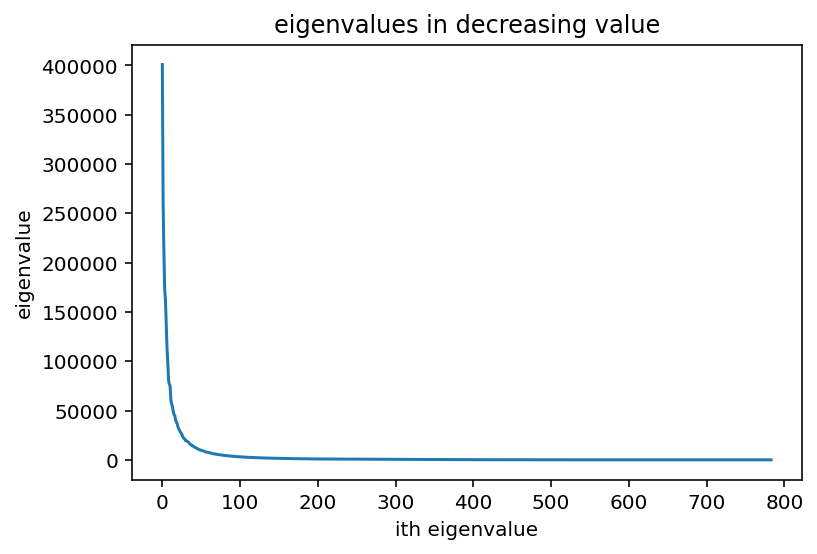

In [203]:
plt.plot(np.arange(0, values.shape[0], 1, dtype=int),np.real(values))
plt.xlabel('ith eigenvalue')
plt.ylabel('eigenvalue');
plt.title('eigenvalues in decreasing value');

<font size="3.5">Q 2. Plot cumulative explained variance ratio as a function of the number of
components.</font>

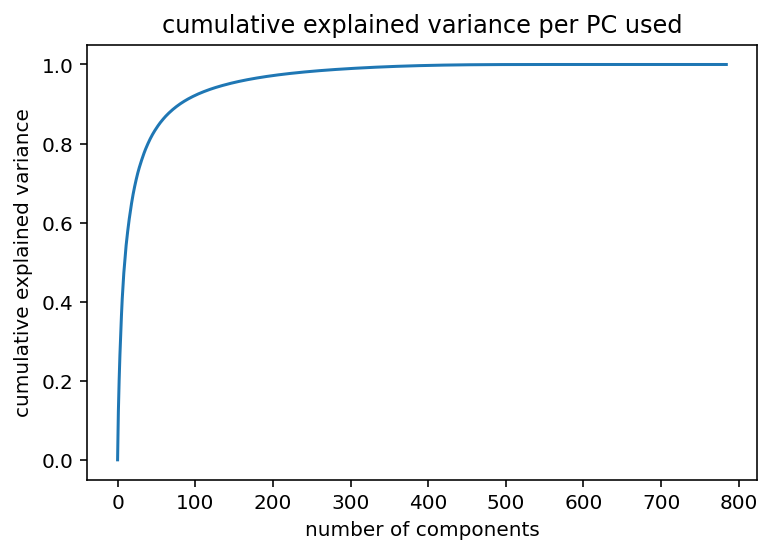

In [204]:
plt.plot(np.concatenate([[0], np.cumsum(np.real(values) / np.real(values).sum())]))
plt.gca().xaxis.get_major_locator().set_params(integer=True)
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');
plt.title('cumulative explained variance per PC used');

We can see that the eigenvalues decrease very very fast. 

And as expected, the number of components until the ~100 largely increases the cumulative explained variance

<font size="3.5">Q 3.1 Plot 𝑒𝑟𝑟(𝒳 , 𝑚) as a function of 𝑚 where 𝑚 = 1, . . . , 784.</font>

In [147]:
x_rec_all = []
x_err_all = []
pcaComponents = pca.components_
projection = (images_of_two_5k-mean)@(pcaComponents.T)
for n_comp in range(0,images_of_two_5k.shape[1]):
    x_rec = (projection[:,:n_comp])@(pcaComponents[:n_comp]) + mean
    x_rec_all.append(copy.deepcopy(x_rec))
    x_err = np.mean(np.linalg.norm(images_of_two_5k-x_rec, axis=1)**2)
    x_err_all.append(x_err)

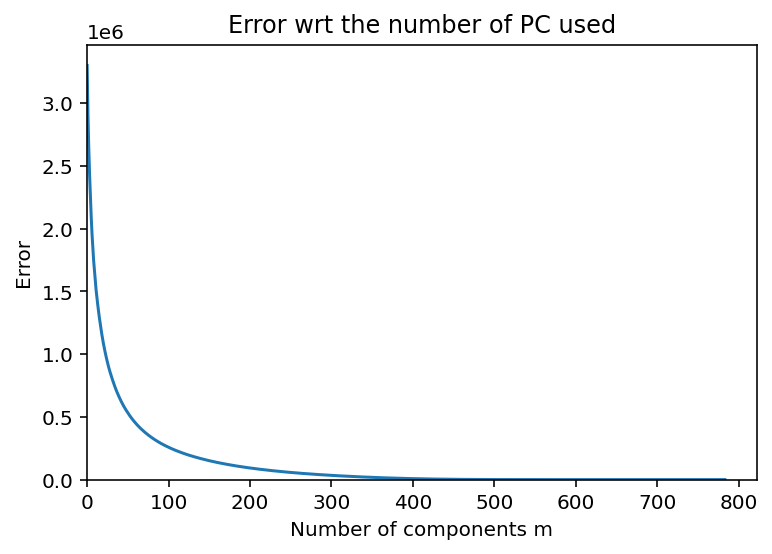

In [148]:
plt.plot(np.arange(0,images_of_two_5k.shape[1],1), x_err_all)
plt.xlim(xmin=0)
plt.ylim(ymin=0)
plt.title('Error wrt the number of PC used')
plt.ylabel('Error')
plt.xlabel('Number of components m')
plt.show()

<font size="3.5">Q 3.2 Find 𝑚 that corresponds to accuracy 50%, 95% and 99% (same as error 0.5, 0.05, 0.01).</font>

In [149]:
accuracy = [0.5,0.05,0.01]
array_x_err_all = np.array(x_err_all)
max_err = np.max(array_x_err_all) # -> corresponds to 100% error
min_err = np.min(array_x_err_all) # -> corresponds to 0% error

for acc in accuracy:
    corresponding_val_to_acc = (max_err + min_err)/(1/acc)
    nb_comp = np.argmin(np.abs(array_x_err_all - corresponding_val_to_acc))
    print(nb_comp, "principal components are required to have",100 - 100/(1/acc), "% accuracy")
    


9 principal components are required to have 50.0 % accuracy
141 principal components are required to have 95.0 % accuracy
302 principal components are required to have 99.0 % accuracy


As expected, the more principal components you have, the more accuracy you have 

However, we can see that the significant gains in performance, are visible only until we add the 141 th component, after that the gains are slower and slower 

Which means that some components, the ones with largest variance, are the ones that most impact our results

<font size="3.5">Q 4. Compare all three previous plots. Do you notice anything in common? Could you explain anything?</font>

In all of the plots, we see the same trend, very fast growth, and then at some point, a much slower growth 

This effect is obviously not random, its by construction 

We give more importance to PC with the largest variance, because they carry the most information, where as the ones with least variance, are less importance

<font size="3.5">5. Plot the mean vector of 𝒳 and first 10 principal components.</font>

<font size="3.5">6. Sample 5 random images of digit 2 from MNIST (outside from 𝒳 ). For each image ℐ in this 5 samples and for each 𝑚 = 1, 2, . . . , 10, reconstruct image from m PC, compute loss</font>

In [166]:
def image_reconstruction(imgs, nb_comp):
    x_rec_all = []
    pcaComponents = pca.components_
    projection = (imgs-mean)@(pcaComponents.T)
    for n_comp in range(1,nb_comp + 1): # 1 to n first components
        x_rec = (projection[:,:n_comp])@(pcaComponents[:n_comp]) + mean
        x_rec_all.append(copy.deepcopy(x_rec))
    return x_rec_all


#sample 5 random images
rng = random.sample(range(images_of_two.shape[0]), 5)
images_of_two_5 = images_of_two[rng,:]

In [167]:
reconstruction = image_reconstruction(images_of_two_5,10)
print(reconstruction)
images_of_two_5.shape

(5, 784)

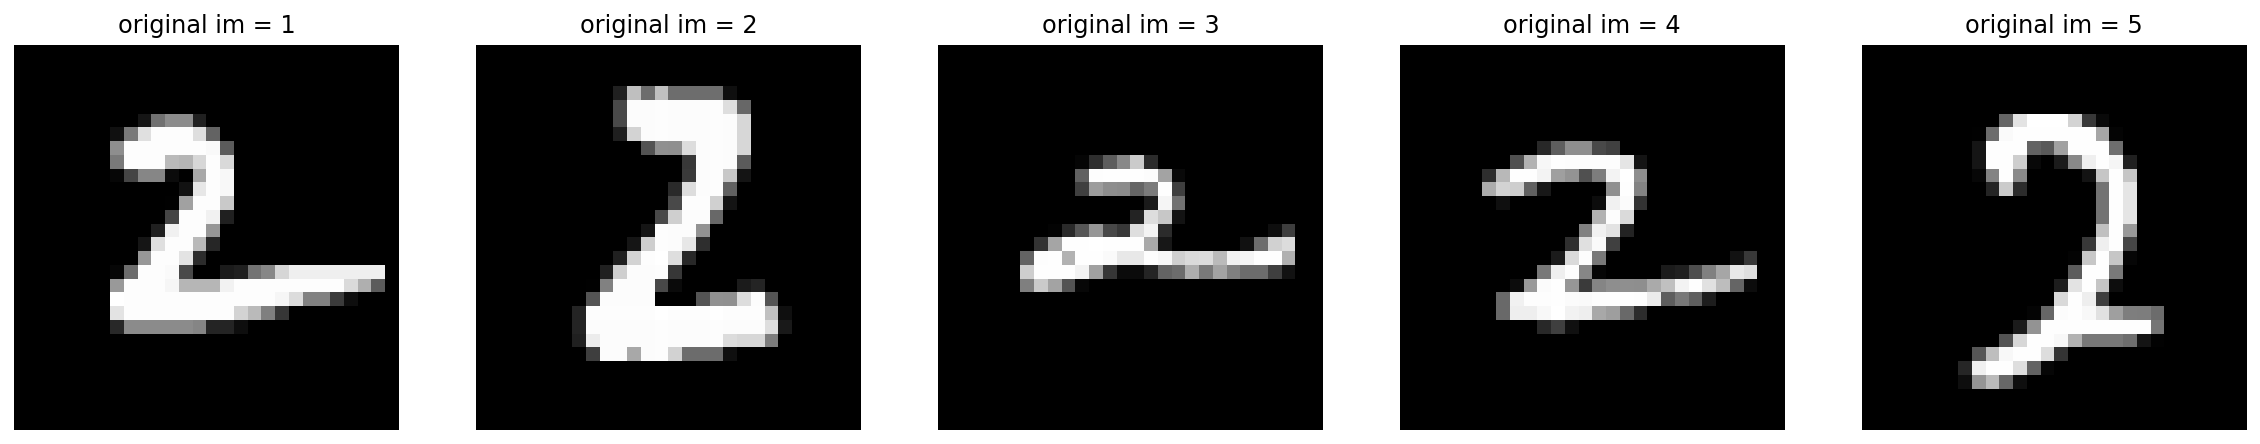

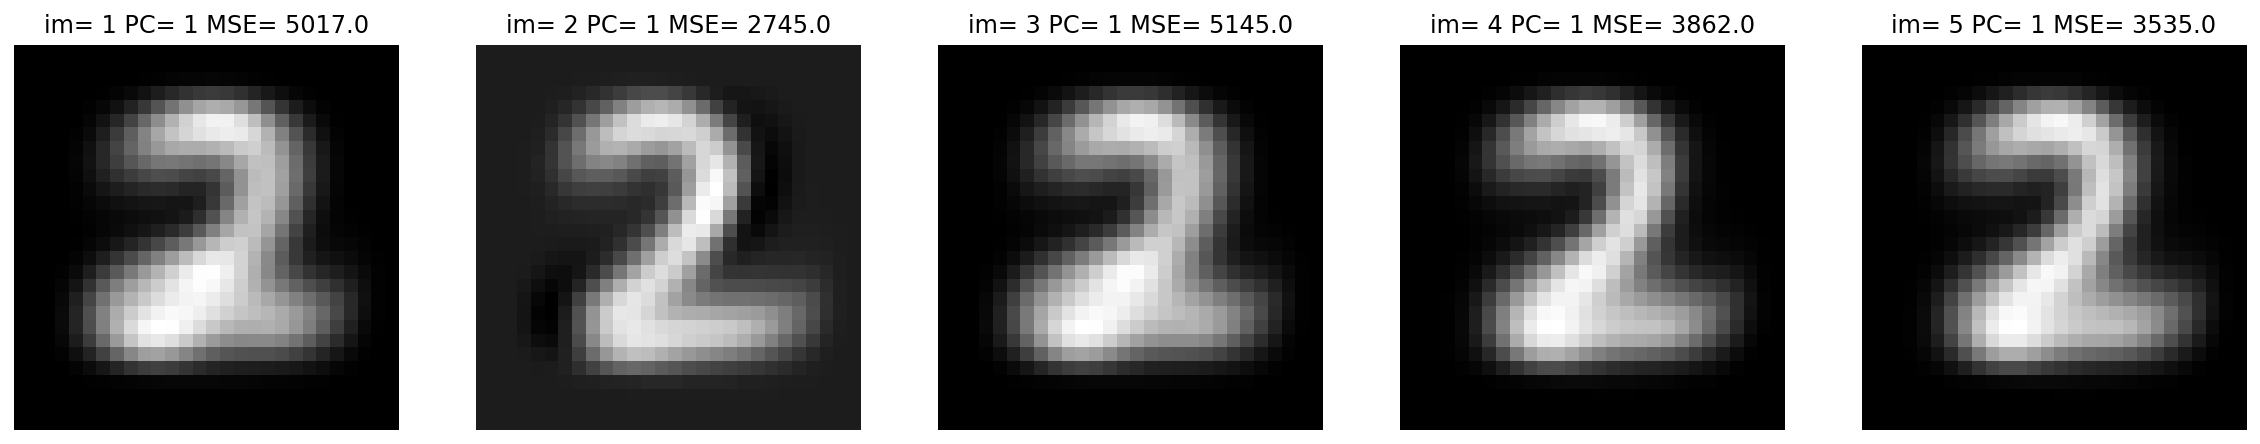

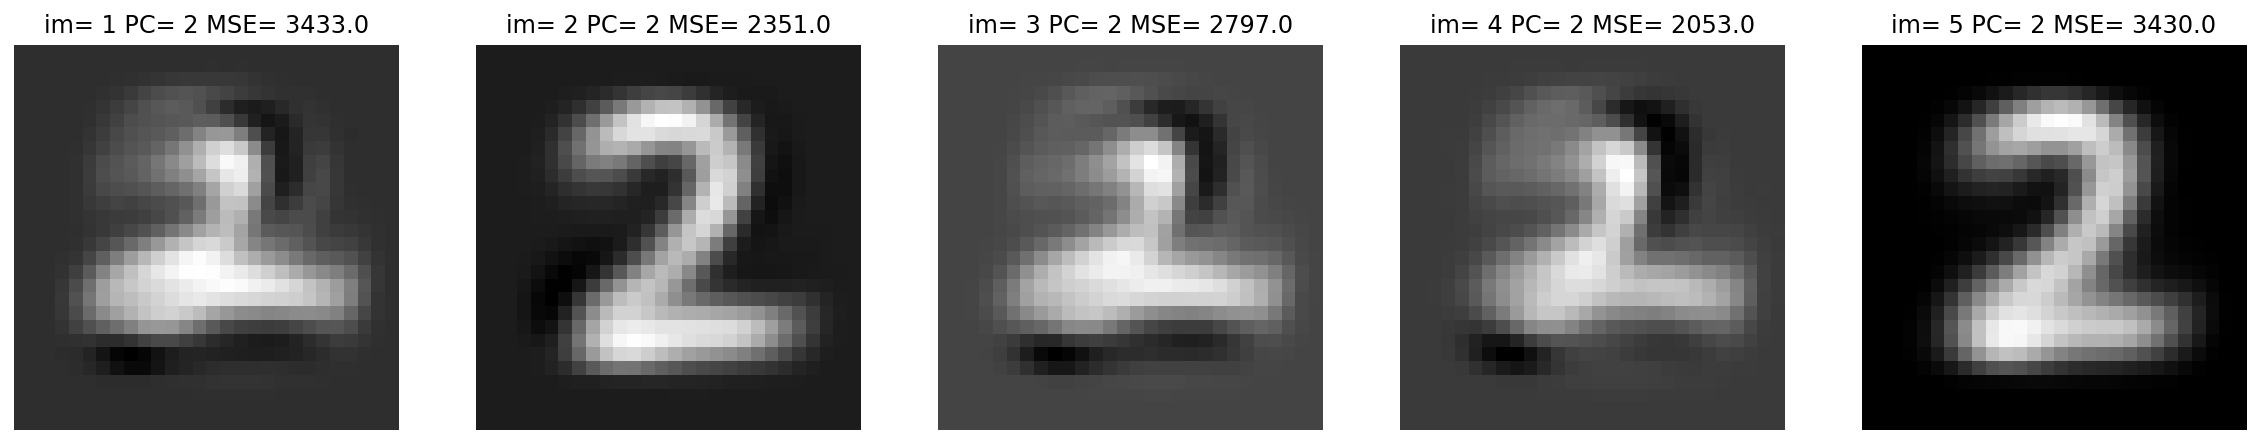

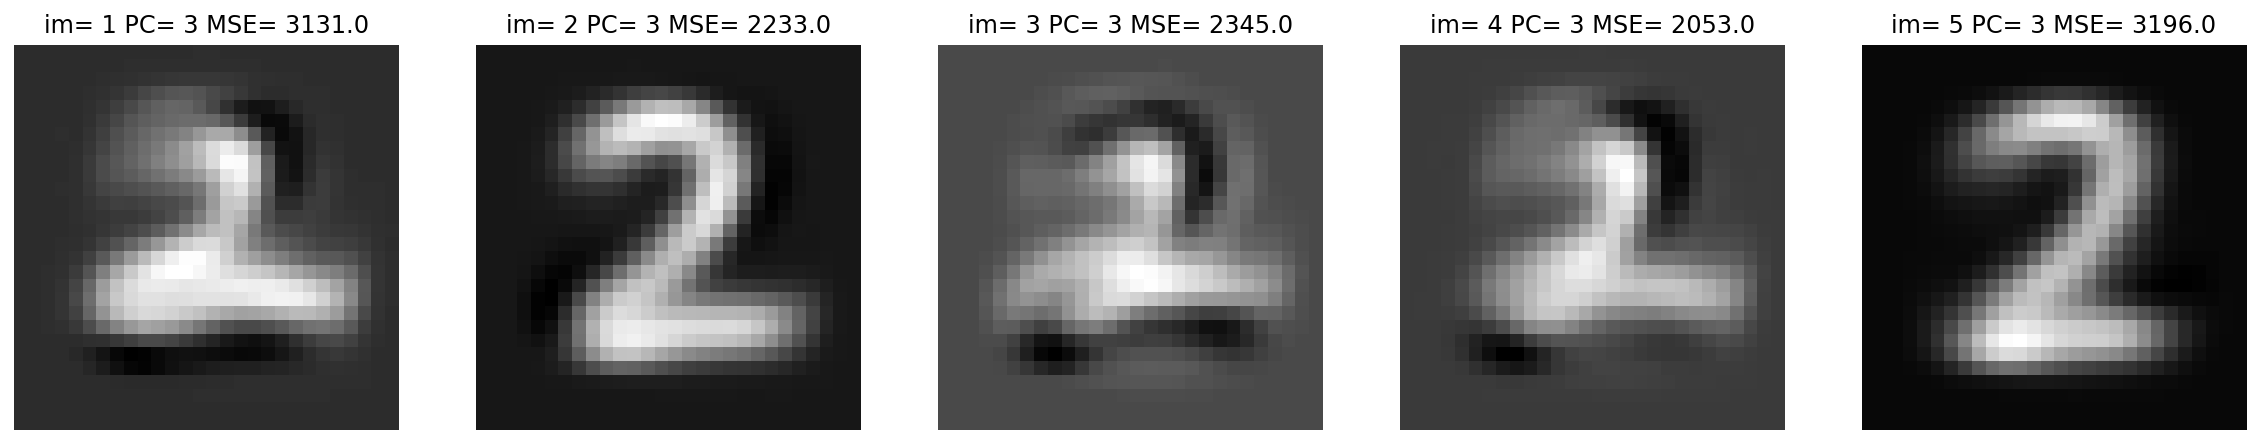

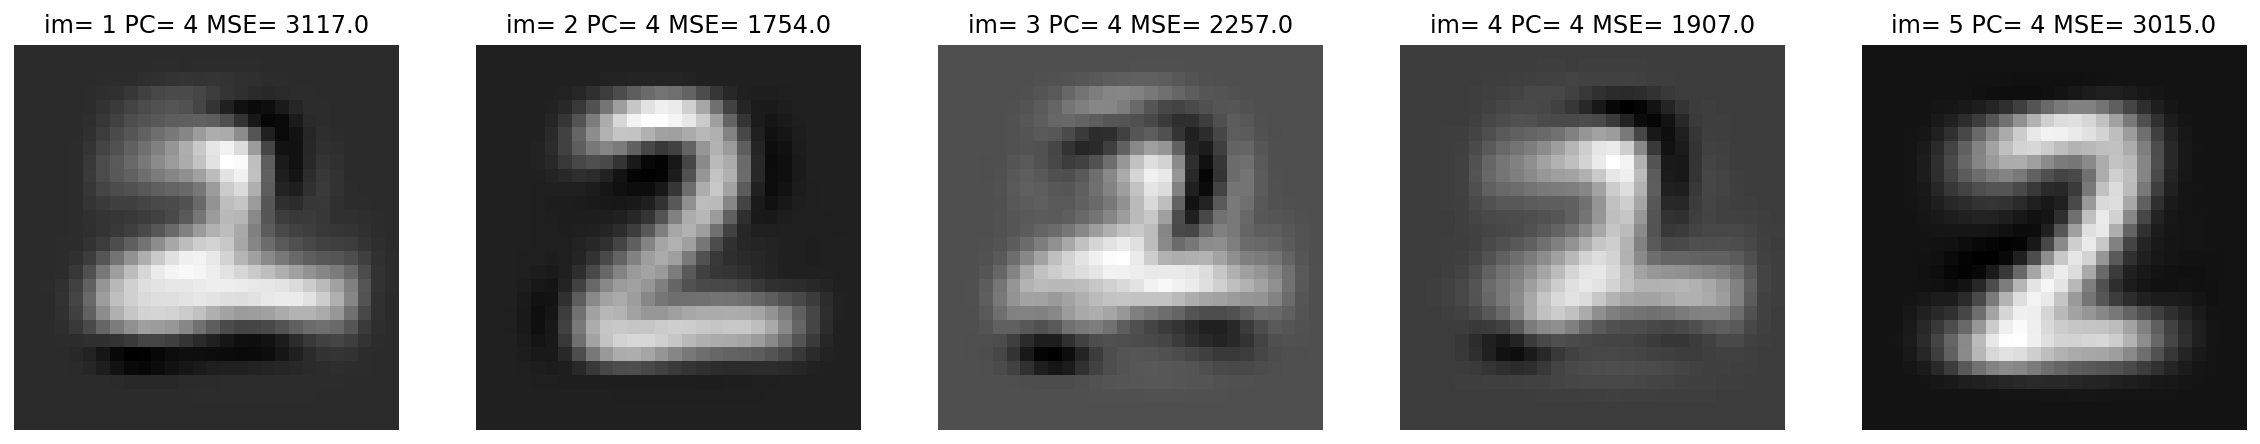

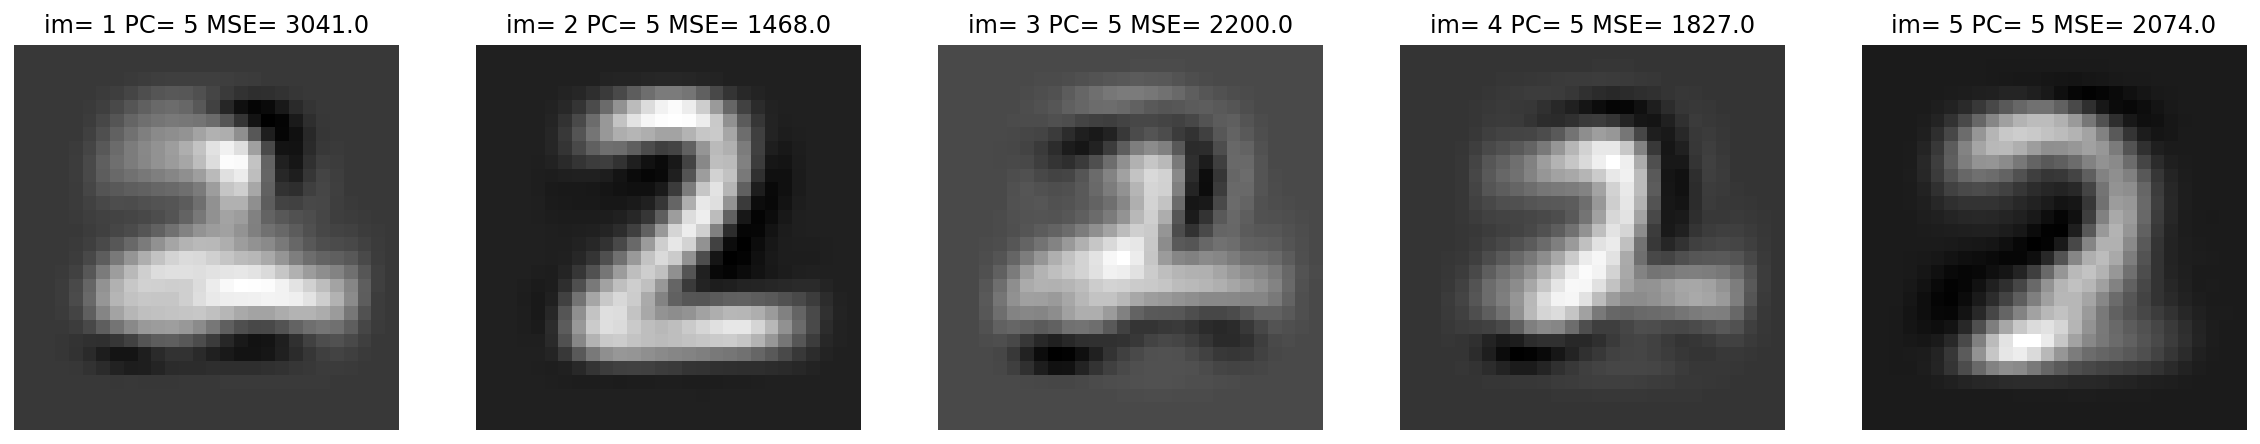

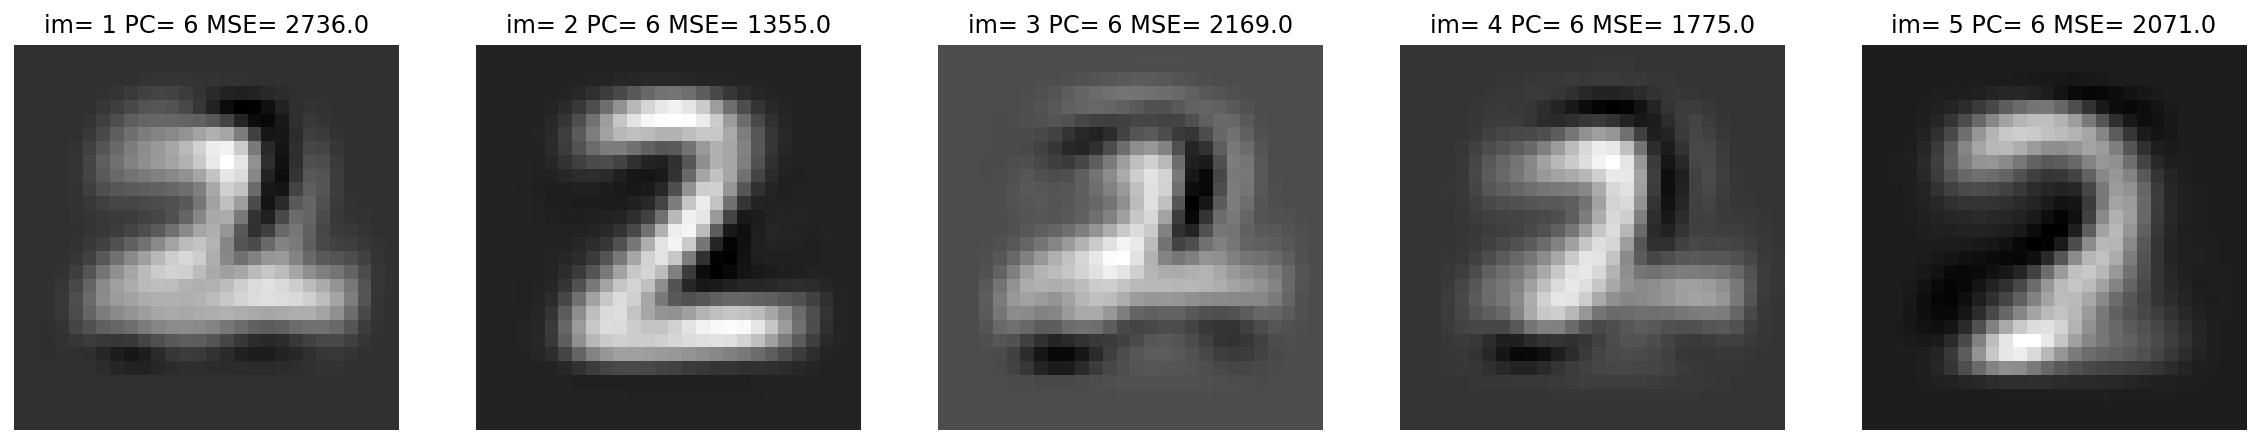

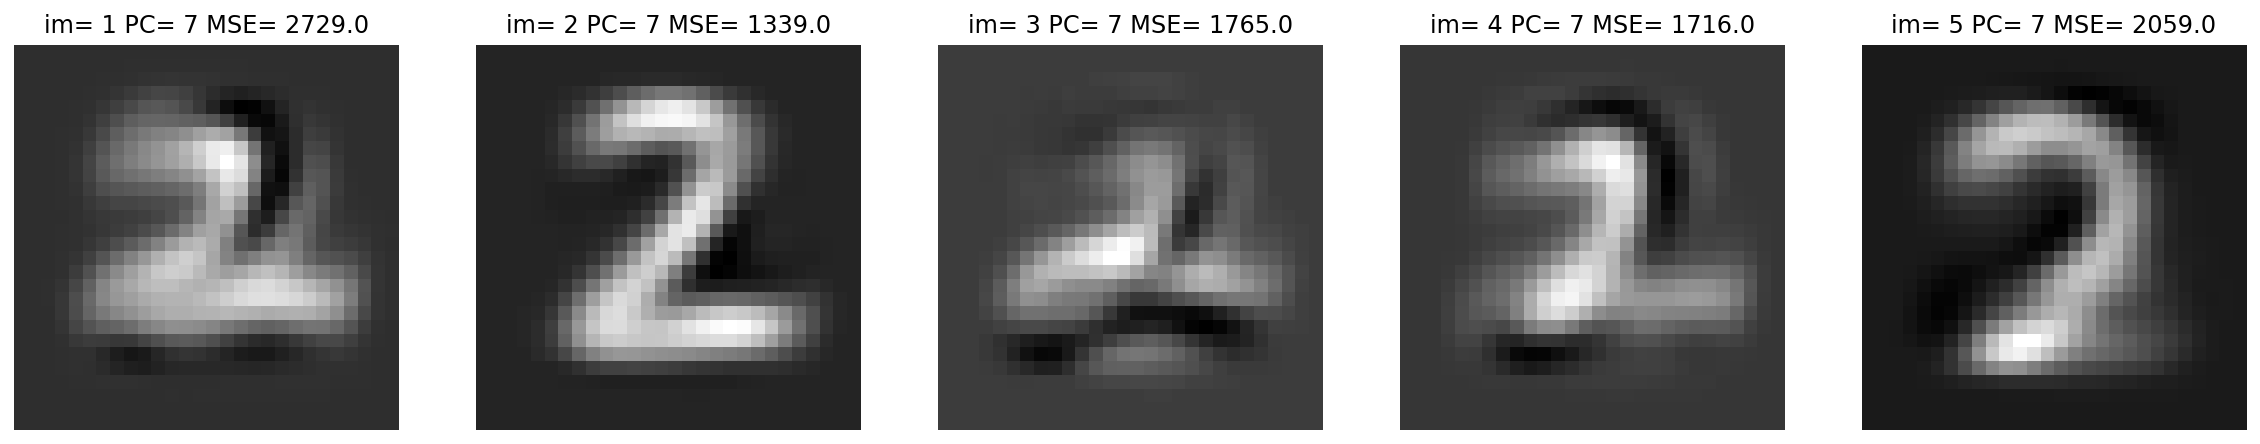

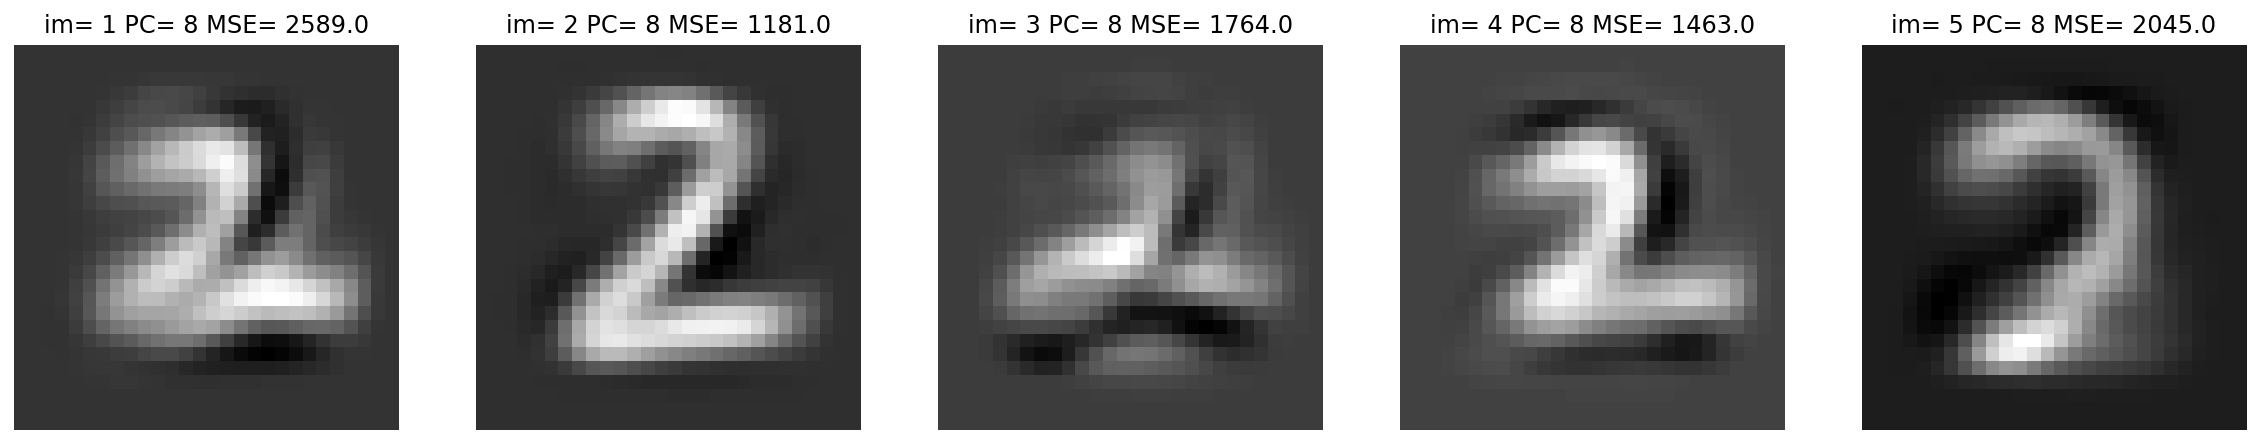

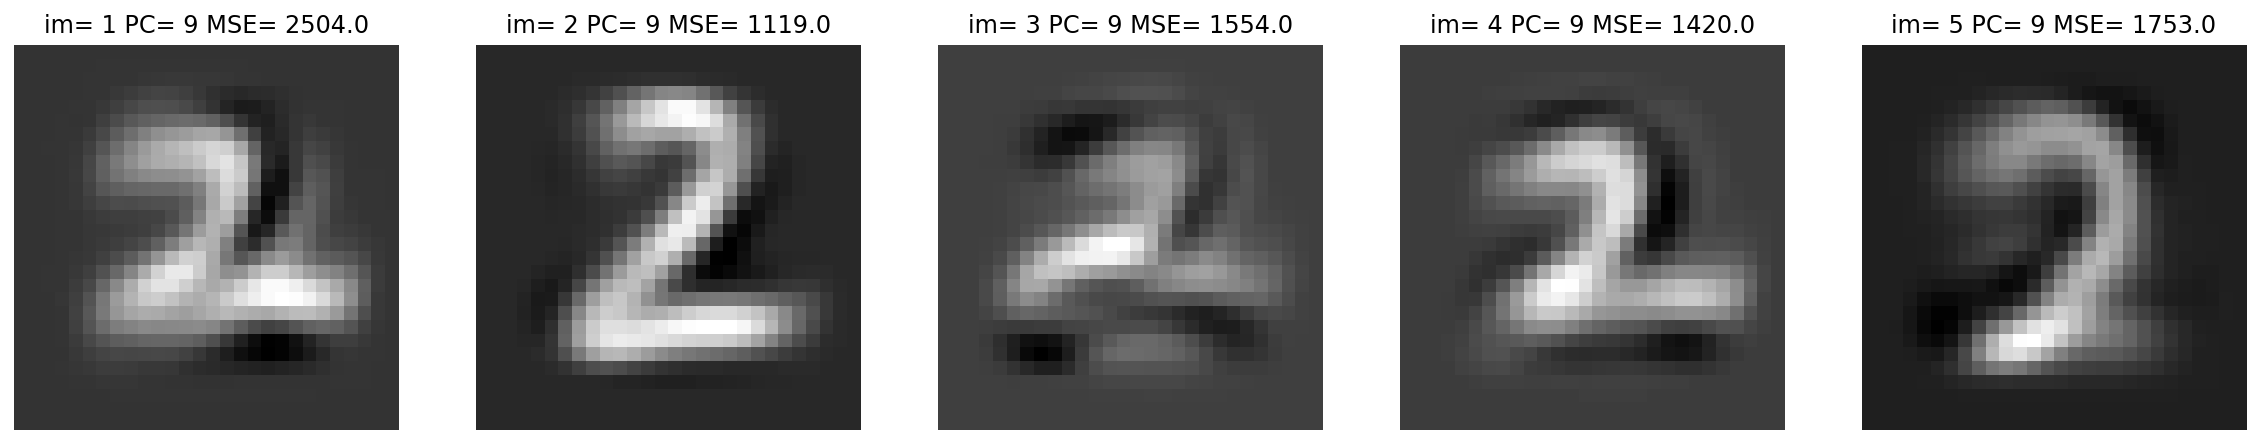

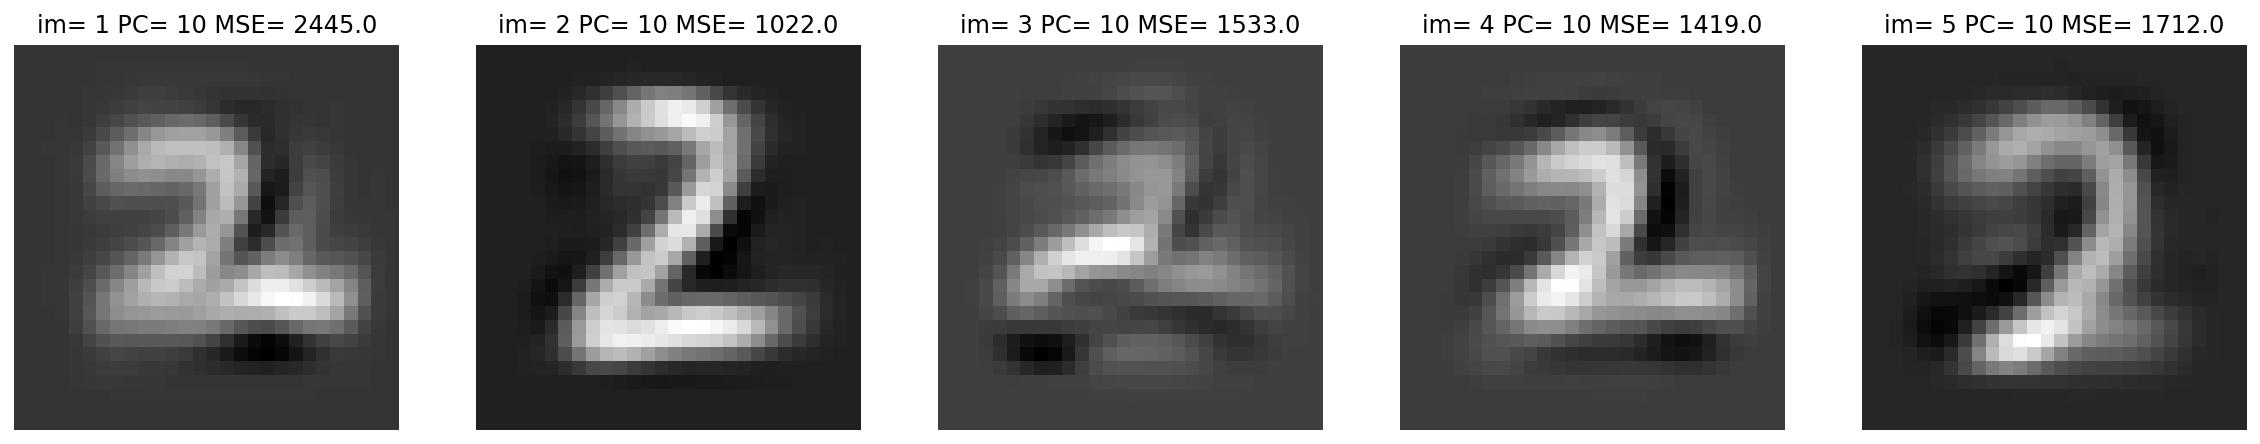

In [200]:
fig = plt.figure(figsize=(20,300))
rows = 1
columns = 5
for i in range(images_of_two_5.shape[0]):
        fig.add_subplot(rows, columns, i+1)
        plt.imshow(images_of_two_5[i,:].reshape(28,28))
        plt.axis('off')
        plt.title('original im = '+str(i+1))
        
for j in range(0,10):
    fig = plt.figure(figsize=(20,300))
    rows = 1
    columns = 5
    for i in range(images_of_two_5.shape[0]):
        fig.add_subplot(rows, columns, i+1)
        mse = mean_squared_error(images_of_two_5[i,:], reconstruction[j][i,:])
        plt.imshow(reconstruction[j][i,:].reshape(28,28))
        plt.axis('off')
        plt.title('im= '+str(i+1)+' PC= '+str(j+1) + ' MSE= '+str(np.round(mse)))
        
        
    